The goal of this notebook is to give some insights into the interpretation of the resulting model. **Comprehensive data exploratory analysis is not the goal of this notebook**. For this notebook to work, files X_train_concat.zip and y_concat.zip (outputs of the script src/features/concat_X_y.py or of the command ```make concat_X_y```) should be available in the folder data/final_concat. The model estimation is the same as in src/models/train_model.py.

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import os
from src.configs import lgb_params
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split

# allow several outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
input_filepath = '../../data/final_concat'

### 1. Basic information on the data

The second line in the next cell rearranges the columns. Of course in general results should  not depend on the column order, but in this case they slightly do. Apparently a different column order means a different selection of features each boosting round, which mean slightly different resutling trees. This column corresponds to the column order in my original solution. Without this line the score on the Private LB will be slightly worse and will be ranked around 20 ranks lower.

In [3]:
X_train = pd.read_pickle(os.path.join(input_filepath, 'X_train_concat.zip'))
X_train = X_train[list(X_train.columns[:16]) + list(X_train.columns[18:35]) + [X_train.columns[-1]] + list(X_train.columns[35:-1]) + list(X_train.columns[16:18])]
y_train = pd.read_pickle(os.path.join(input_filepath, 'y_concat.zip'))
y_log = np.log1p(y_train)

In [71]:
X_train.shape

(8197781, 66)

The final dataset contains over 8 million rows, where each row corresponds to a unique combination of a visitor (fullVisitorId) and a time window (present_delta=500 days). Each row represents certain features aggregated in a certain way on a given time window for a given visitor.

The next plot represents the target variable (log of total transaction revenue for a combination of a given visitor and a given time window of the size future_delta=108 days). The distribution is highly concentrated close to 0 with a few outliers (a few visitors who are "heavy buyers").

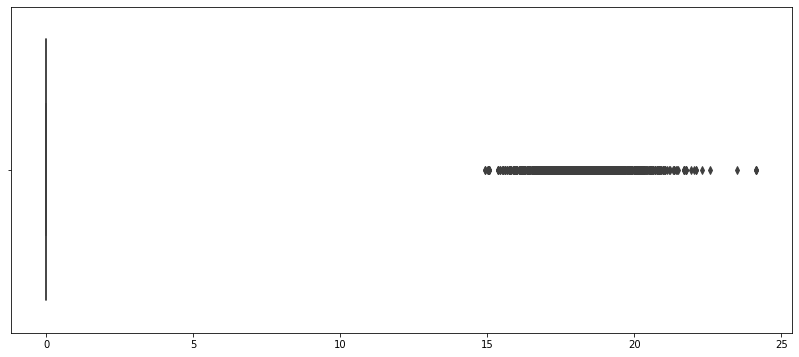

In [89]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.boxplot(y_log, ax=ax);

To be more precise, the values close to 0 are in fact precisely zeros. And just 1355 unique visitors made purchases over various 108-day periods (all in all 2349 values of y_log are non-zero).

In [121]:
y_log[y_log['future_rev'] < 10]['future_rev'].value_counts()
print('Number of unique visitors who made purchases: {}'.format(y_log[y_log['future_rev'] > 0].index.nunique()))  
print('Number of positive revenue values: {}'.format(y_log[y_log['future_rev'] > 0].count()))

0.0    8195432
Name: future_rev, dtype: int64

Number of unique visitors who made purchases: 1355
Number of positive revenue values: future_rev    2349
dtype: int64


We have 66 features in the final dataset, all of them are recoded to numeric types, but LightGBM requires an indication of the features that are to be treated as categorical. We are doing this in the next section when training the model.

In [125]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8197781 entries, 0000000259678714014 to 9999997304197521748
Data columns (total 66 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   channelGrouping_MODE                int32  
 1   channelGrouping_COUNT               int64  
 2   count_ViewedCat_MEAN                float64
 3   device_browser_MODE                 int32  
 4   device_deviceCategory_MODE          int32  
 5   device_operatingSystem_MODE         float64
 6   geoNetwork_city_MODE                float64
 7   referSocNetwork_MODE                int32  
 8   totals_bounces_MEAN                 float64
 9   trafficSource_campaign_recod_SUM    int64  
 10  trafficSource_campaign_recod_MEAN   float64
 11  trafficSource_isTrueDirect_SUM      int16  
 12  trafficSource_keyword_recod_SUM     int64  
 13  trafficSource_keyword_recod_MEAN    float64
 14  trafficSource_source_recod_SUM      int64  
 15  trafficSource_source_rec

In [126]:
X_train.head()

,channelGrouping_MODE,channelGrouping_COUNT,count_ViewedCat_MEAN,device_browser_MODE,device_deviceCategory_MODE,device_operatingSystem_MODE,geoNetwork_city_MODE,referSocNetwork_MODE,totals_bounces_MEAN,trafficSource_campaign_recod_SUM,...,weightRev_3,weightRev_4,weightRev_5,weightRev_6,weightRev_7,weightRev_8,weightRev_9,weightRev_10,referURL_recod_SUM,referURL_recod_MEAN
fullVisitorId,,,,,,,,,,,,,,,,,,,,,
0000000259678714014,2,2,2.0,1,1,3.0,26.0,0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
0000010278554503158,2,1,5.0,1,1,3.0,NaN,0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
0000020424342248747,2,1,6.0,1,1,1.0,51.0,0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
0000027376579751715,2,1,3.0,1,1,3.0,NaN,0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
0000039460501403861,1,1,1.0,1,1,1.0,NaN,1,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0


### 2. Model training

As mentioned in the README, we did not conduct any hyperparameter tuning. Judging by the results of other contestants, this would have probably had a minor effect on the results. Validation (or cross-validation) was not conducted either due to time constraints.

In [4]:
cat_feat = ['channelGrouping_MODE', 'device_browser_MODE', 
                'device_deviceCategory_MODE', 'device_operatingSystem_MODE', 
                'geoNetwork_city_MODE', 'referSocNetwork_MODE']
    
dtrain = lgb.Dataset(X_train, y_log, free_raw_data=False, silent=False, 
                     categorical_feature=cat_feat)
    
lgbm_model = lgb.train(params=lgb_params, 
                           train_set=dtrain,  
                           valid_sets=[dtrain],
                           categorical_feature=cat_feat, 
                           verbose_eval=100
                           )

C:\Users\Michael\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Michael\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.29344
[200]	training's rmse: 0.289785
[300]	training's rmse: 0.287192
[400]	training's rmse: 0.285036
[500]	training's rmse: 0.282964
[600]	training's rmse: 0.28121
[700]	training's rmse: 0.279435
[800]	training's rmse: 0.277866
[900]	training's rmse: 0.276447
[1000]	training's rmse: 0.275087
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.275087


### 3. Interpretation of the results

#### a. Out-of-the-box feature importances

Let us depict the importance of the feaures. LightGBM calculates feature importance using two approaches out-of-the-box: 'split' (the result contains numbers of times the feature is used in a model) and 'gain' (the result contains total gains of splits which use the feature). In the literature, both approaches were found to be misleading under certain circumstances as was their widely  used alternative - permutation importances (not used here).

We see that in terms of 5 most important feaures the approaches agree on the particular importance of:

- timeShift_1 (time from the last transaction to the beginning of the time window, on which the revenue was calculated)
- aggregations of sessionQualityDim (metric calculated by Google)
- last revenue / weighted last revenue

The city and share of "promo views" were also relatively important, but according to just one approach each.

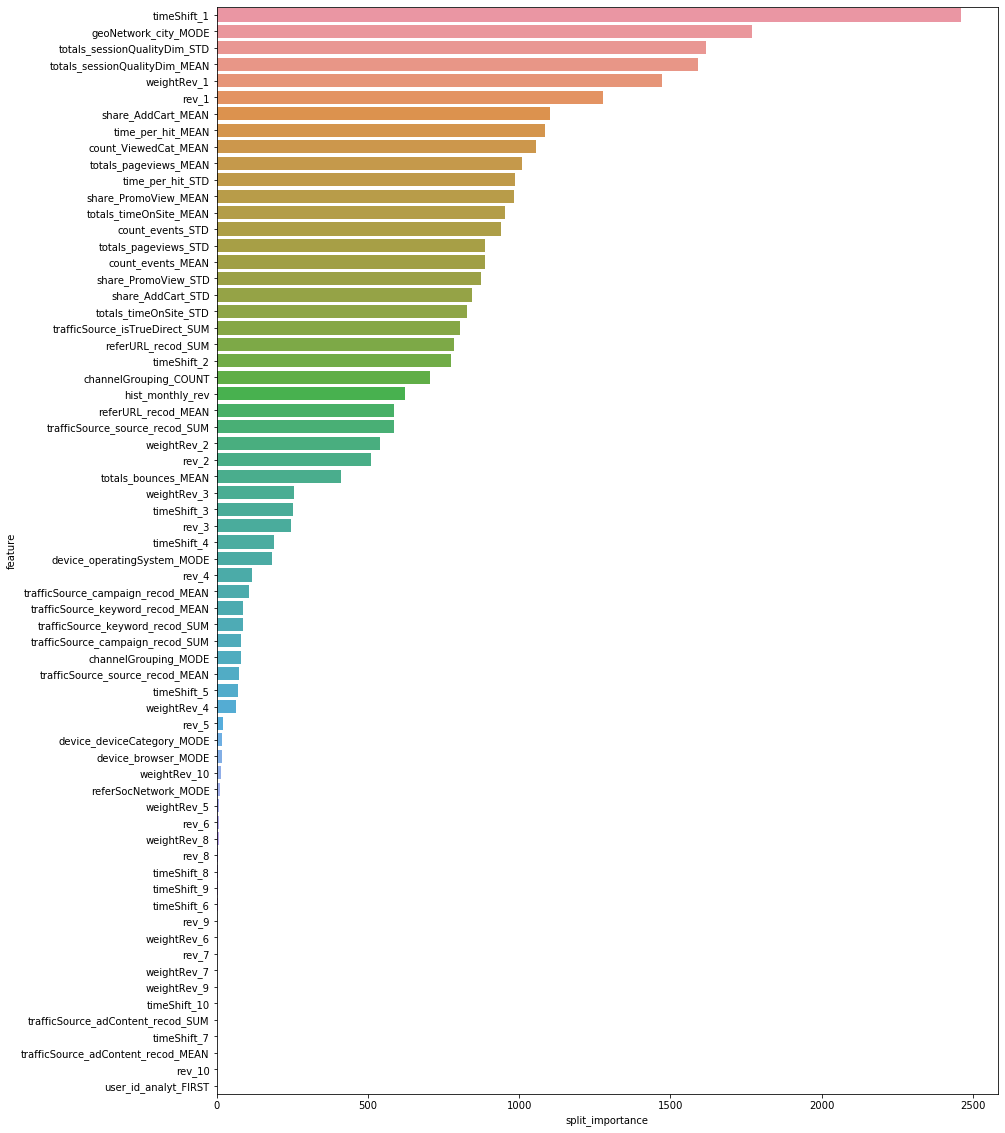

In [35]:
plt.figure(figsize=(14, 20))
sns.barplot(x='split_importance', y='feature', 
            data=pd.DataFrame({'feature': lgbm_model.feature_name(),
                              'split_importance': lgbm_model.feature_importance('split')})
            .sort_values(by='split_importance', ascending=False))

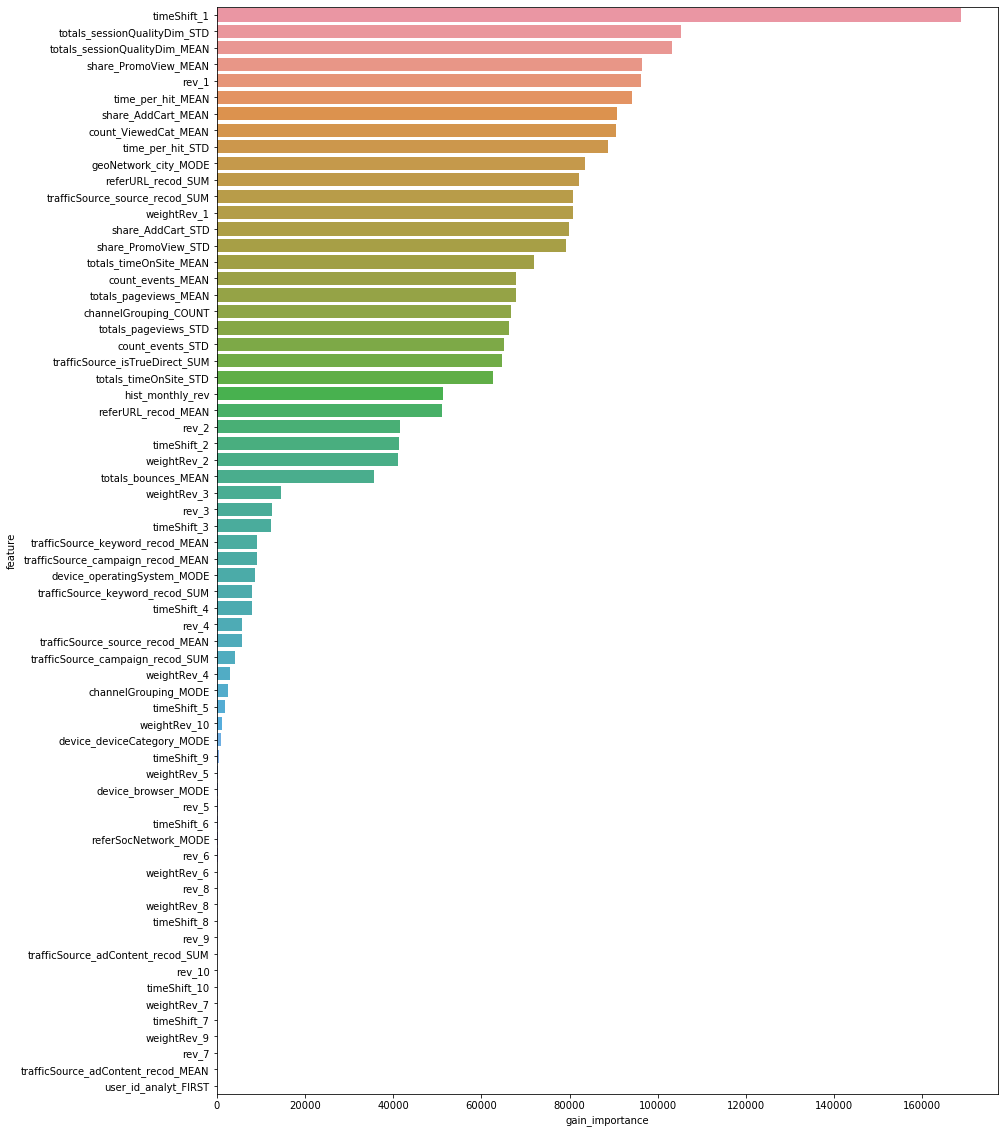

In [34]:
plt.figure(figsize=(14, 20))
sns.barplot(x='gain_importance', y='feature', 
            data=pd.DataFrame({'feature': lgbm_model.feature_name(),
                              'gain_importance': lgbm_model.feature_importance('gain')})
            .sort_values(by='gain_importance', ascending=False))

#### b. Drop-column importances

As pointed out by some researchers (https://explained.ai/rf-importance/index.html), the brute force drop-column  mechanism is the most accurate algorithm to gauge feature importance, but also the most computation-intensive one because requires a re-estimation of hte whole model. Its motivation is very straightforward - estimate by how much the performance of the full model gets worse if a particular feature is removed. Here we can measure the performace both on the data seen by the model ("training" data) and not seen by it ("validation" data). Train/validation split was not performed previously and was not necessary because of the decision not to optimise model hyperparameters, hence there was not way to influence the model performance on a possible validation set.

Estimation of importance for all 66 features is indeed time consuming. Let's focus on the most important feautes as defined by the out-of-the-box methods above.

In [4]:
col_to_investigate = [
    'timeShift_1', 'totals_sessionQualityDim_MEAN', 
'totals_sessionQualityDim_STD', 
    'geoNetwork_city_MODE',
'share_PromoView_MEAN' ,'weightRev_1'
]

X_train_tr, X_train_val, y_log_tr, y_log_val = train_test_split(X_train, y_log, test_size=0.2, random_state=42)

Wall time: 19 s


In [46]:
cat_feat = ['channelGrouping_MODE', 'device_browser_MODE', 
                'device_deviceCategory_MODE', 'device_operatingSystem_MODE', 
                'geoNetwork_city_MODE', 'referSocNetwork_MODE']
def get_score(X_train_tr, y_log_tr, X_train_val, y_log_val, col):
    cat_feat_custom = cat_feat.copy()
    if col in cat_feat_custom:
        # adjust list of categorical features to avoid error messages
        cat_feat_custom.remove(col)
    dtrain = lgb.Dataset(X_train_tr, y_log_tr, free_raw_data=False,  
                     categorical_feature=cat_feat_custom)
    dvalid = lgb.Dataset(X_train_val, y_log_val, free_raw_data=False,  
                     categorical_feature=cat_feat_custom)
    lgbm_model = lgb.train(params=lgb_params, 
                           train_set=dtrain,  
                           valid_sets=[dtrain, dvalid],
                           categorical_feature=cat_feat, 
                           verbose_eval=0
                           )
    return lgbm_model.best_score['training']['rmse'], lgbm_model.best_score['valid_1']['rmse']

In [82]:
baseline_score_train = lgbm_model.best_score['training']['rmse']
baseline_score_valid = lgbm_model.best_score['valid_1']['rmse']
# 0.2768615707607538 training
#0.28852525693877085 valid

Append all tuples of importances (train, valid) to a list.

In [48]:
importances = []
for col in col_to_investigate:
    print(col)
    col_score = get_score(X_train_tr.drop(columns=[col]), y_log_tr, X_train_val.drop(columns=[col]), y_log_val, col)
    importances.append(col_score) # should be negative, rmse without a column should be higher

timeShift_1
totals_sessionQualityDim_MEAN
totals_sessionQualityDim_STD
geoNetwork_city_MODE
share_PromoView_MEAN
weightRev_1


Since the score is RMSE (lower is better), the difference score_without_feature - baseline_score will be higher if the feature is more important.

In [54]:
import_df = pd.DataFrame.from_records(importances, index=col_to_investigate, 
                                      columns=['train', 'valid'])
import_df['train'] = import_df['train'] - baseline_score_train
import_df['valid'] = import_df['valid'] - baseline_score_valid
import_df

,train,valid
timeShift_1,0.001192,-0.000307
totals_sessionQualityDim_MEAN,-0.000006,0.000673
totals_sessionQualityDim_STD,0.001072,0.000390
geoNetwork_city_MODE,0.002586,0.000999
share_PromoView_MEAN,0.002235,0.001046
weightRev_1,0.002334,0.000825


Below are the importance rankings for the train and validation sets. As it turns out, they do not really agree with each other, but the significance of each feature taken separately doesn't seem to be high anyway (though no tests were conducted to test for significance).

In [55]:
import_df['train'].sort_values(ascending=False)

geoNetwork_city_MODE             0.002586
weightRev_1                      0.002334
share_PromoView_MEAN             0.002235
timeShift_1                      0.001192
totals_sessionQualityDim_STD     0.001072
totals_sessionQualityDim_MEAN   -0.000006
Name: train, dtype: float64

In [56]:
import_df['valid'].sort_values(ascending=False)

share_PromoView_MEAN             0.001046
geoNetwork_city_MODE             0.000999
weightRev_1                      0.000825
totals_sessionQualityDim_MEAN    0.000673
totals_sessionQualityDim_STD     0.000390
timeShift_1                     -0.000307
Name: valid, dtype: float64

Finally, let us show the distribution of the split values for these features. We'll note that it seems sensible that most split values for timeShift_1 are concentrated close to zero (even though the absolute majority of observations have an arbitrarily chosen number 10000000 as the value) - it is the fact of recency of the last purchase that seems to have explanatory power at least for the training data. The shape of distribution of weightRev_1 split values is apparently related to the shape of the distribtion of the feature itself. Split values for other features should be probably accepted as a fact.

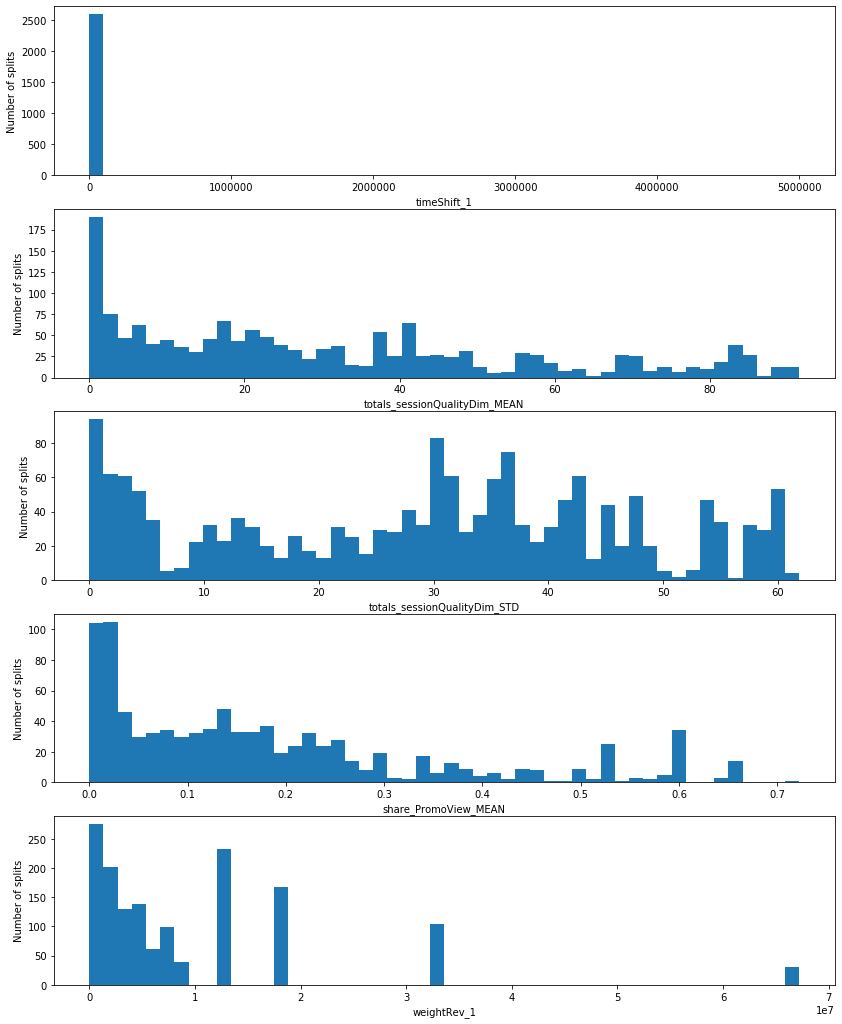

In [115]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(14, 18) )
for i, col in enumerate(pd.Index(col_to_investigate).drop(['geoNetwork_city_MODE'])): # categorical features are not supported
    #print('Split value histogram for {}'.format(col))
    height, x_bins = lgbm_model.get_split_value_histogram(col, bins=50, xgboost_style=False)#.sort_values(by='Count', ascending=False)
    #plt.figure(figsize=(14, 20))
    ax[i].bar(x_bins[:-1], height, width=x_bins[1]-x_bins[0], align='edge')
    ax[i].set(xlabel=col, ylabel='Number of splits')
pass;